In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from PIL import Image

In [3]:
def overayimg(bg, ory, idx):
    bg = np.uint8(bg_img.getdata()).reshape( bg_img.size[0],bg_img.size[1],3)
    plt.imsave('./out/%03d_input.png' % idx, bg)
    bg = Image.fromarray(bg).convert('RGB')
    #bg.putalpha(255)
    plt.subplot(121); plt.imshow(bg);
    
    cm_hot = mpl.cm.get_cmap('Reds');
    ory = np.array(ory);
    ory = np.uint8(cm_hot(ory)*255);
    ory = Image.fromarray(ory).convert('RGB')
    #ory.putalpha(80)
    #plt.figure();plt.imshow(ory);
    
    #pale = Image.alpha_composite(pale, ory)
    pale = Image.blend(bg,ory,alpha=0.25)
    pale.save('./out/%03d_result.png' % idx)
    plt.subplot(122); plt.imshow(pale);
    
    plt.show()
    
    return ory

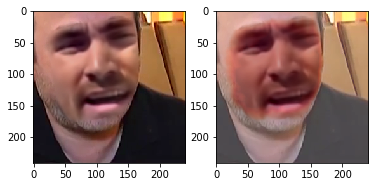

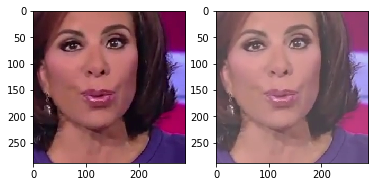

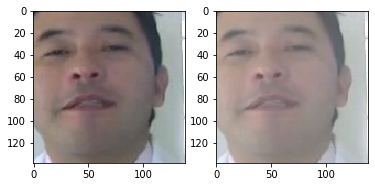

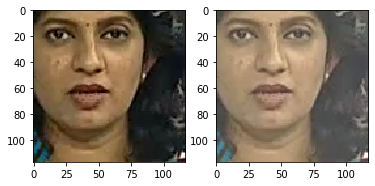

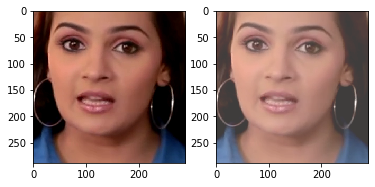

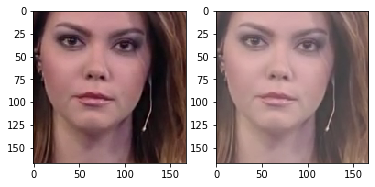

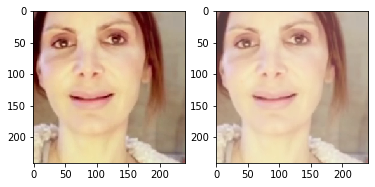

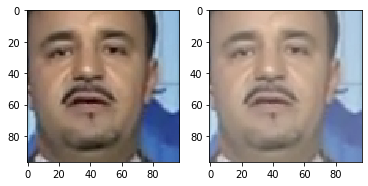

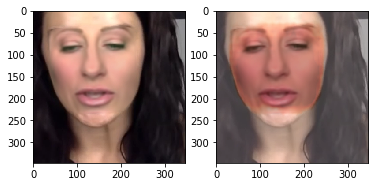

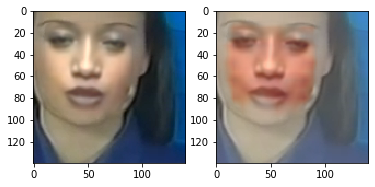

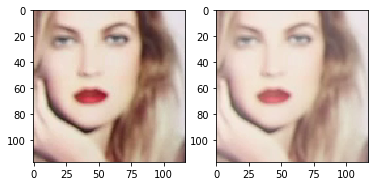

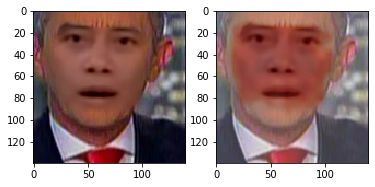

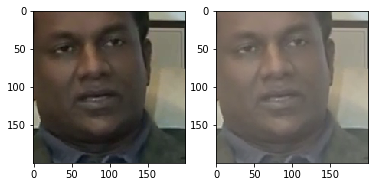

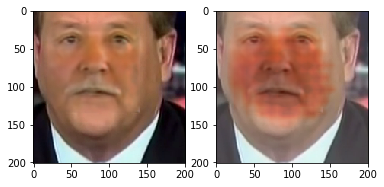

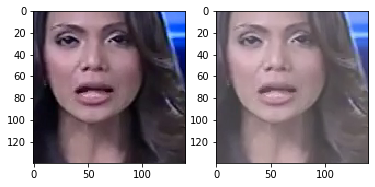

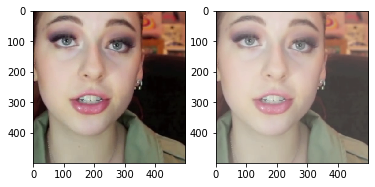

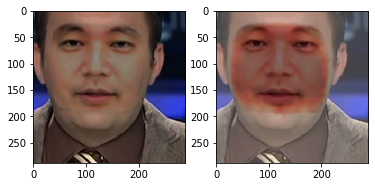

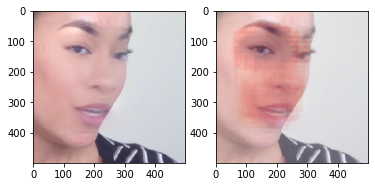

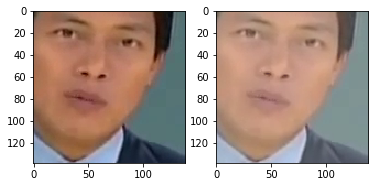

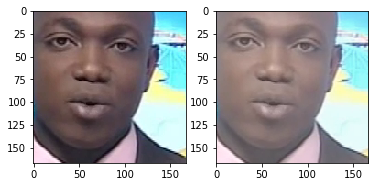

In [4]:
for i in range(20):
    bg_img = Image.open('/datasets/FaceForensics/exp/mobilenetv2_dump/vis/segmentation_results/%06d_image.png' % i)
    ov_img = Image.open('/datasets/FaceForensics/exp/mobilenetv2_dump/vis/segmentation_results/%06d_prediction.png' % i)
    overayimg(bg_img, ov_img, i);

In [3]:
from __future__ import print_function
from grpc.beta import implementations
import tensorflow as tf
from tensorflow_serving.apis import predict_pb2
from tensorflow_serving.apis import prediction_service_pb2
import requests
import numpy as np
try:
    from StringIO import StringIO
except ImportError:
    from io import StringIO

In [4]:
server = 'localhost:9123'
host, port = server.split(':')

In [5]:
MAX_FRAME_INFER = 8
num_imgs = 8
images = []; hs = []; ws = []
for i in range(MAX_FRAME_INFER):
    if i >= num_imgs:
        img = np.uint8( [0,0,0] )
        w = 1; h=1; c = 3 ## dummy data
    else:
        pimg = Image.open('/datasets/FaceForensics/exp/mobilenetv2_dump/vis/segmentation_results/%06d_image.png' % 
                          (i+8) )
        w, h = pimg.size; c = len(pimg.getbands())
        img = np.uint8( pimg.getdata() )
    images.append( img ) 
    hs.append( h ); ws.append( w );

imgs1d = np.array( [item for sublist in images for item in sublist.ravel()] )
hs = np.array(hs)
ws = np.array(ws)

# dataset = tf.data.Dataset.from_generator(lambda: t, tf.uint8, output_shapes=[None])
# iterator = dataset.make_one_shot_iterator()
# next_element = iterator.get_next()

In [6]:
# create the RPC stub
# create the gRPC stub
options = [('grpc.max_message_length', 64 * 513 * 513 * 3)]
channel = implementations.insecure_channel(host, int(port)) #options = options)
stub = prediction_service_pb2.beta_create_PredictionService_stub(channel)

/usr/local/lib/python3.6/dist-packages/tensorflow_serving/apis/prediction_service_pb2.py:131: DeprecationWarning: beta_create_PredictionService_stub() method is deprecated. This method will be removed in near future versions of TF Serving. Please switch to GA gRPC API in prediction_service_pb2_grpc.
  'prediction_service_pb2_grpc.', DeprecationWarning)


In [13]:
# create the request object and set the name and signature_name params
request = predict_pb2.PredictRequest()
request.model_spec.name = 'deeplab_ff'
request.model_spec.signature_name = 'predict_images'

In [14]:
# fill in the request object with the necessary data
request.inputs['images'].CopyFrom(
    tf.contrib.util.make_tensor_proto(imgs1d.astype(dtype=np.float32), shape=[np.size(imgs1d)]))
request.inputs['imgnum'].CopyFrom(tf.contrib.util.make_tensor_proto(int(num_imgs)))
request.inputs['height'].CopyFrom(tf.contrib.util.make_tensor_proto(hs.astype(dtype=np.int32), shape=[np.size(hs)]))
request.inputs['width'].CopyFrom(tf.contrib.util.make_tensor_proto(ws.astype(dtype=np.int32), shape=[np.size(ws)]))

In [15]:
# sync requests
result_future = stub.Predict(request, 30.)

# For async requests
# result_future = stub.Predict.future(request, 10.)
# result_future = result_future.result()

In [16]:
print( type( result_future.outputs['segmentation_map'] ),'\n', 'size :',
      np.size( result_future.outputs['segmentation_map'].int_val),'\n', 'sum :',
      np.sum( result_future.outputs['segmentation_map'].int_val) )

print( type( result_future.outputs['raw'] ),'\n', 'size :',
      np.size( result_future.outputs['raw'].float_val),'\n', 'sum :',
      np.sum( result_future.outputs['raw'].float_val) )

<class 'tensorflow.core.framework.tensor_pb2.TensorProto'> 
 size : 2105352 
 sum : 13350083
<class 'tensorflow.core.framework.tensor_pb2.TensorProto'> 
 size : 0 
 sum : 0.0


In [11]:
output = np.array(result_future.outputs['segmentation_map'].int_val)
output.shape

(2105352,)

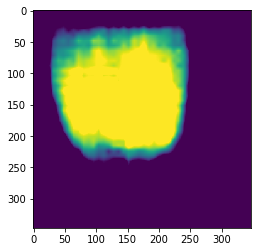

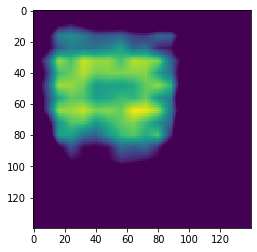

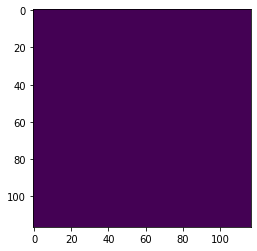

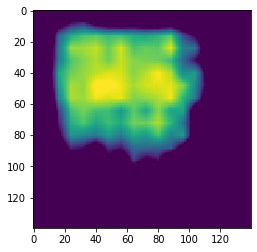

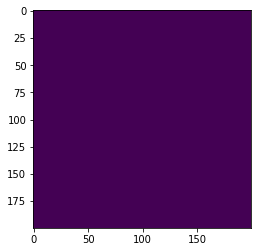

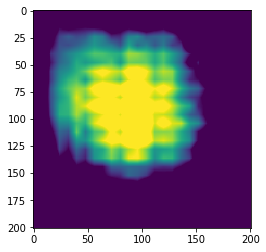

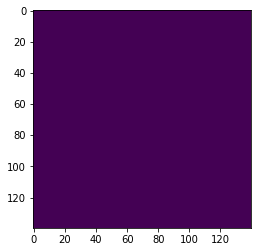

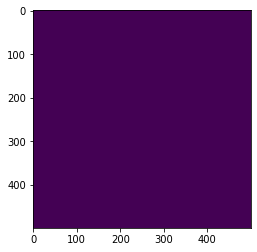

In [12]:
# get the results
output = np.array(result_future.outputs['segmentation_map'].int_val) #int64_val fro predict_labels
h = result_future.outputs['segmentation_map'].tensor_shape.dim[1].size
w = result_future.outputs['segmentation_map'].tensor_shape.dim[2].size

image_mask = np.reshape(output, (MAX_FRAME_INFER, h, w))
for i in range(MAX_FRAME_INFER):
    mask = image_mask[i][:hs[i],:ws[i]]
    plt.imshow(mask)
    plt.show()

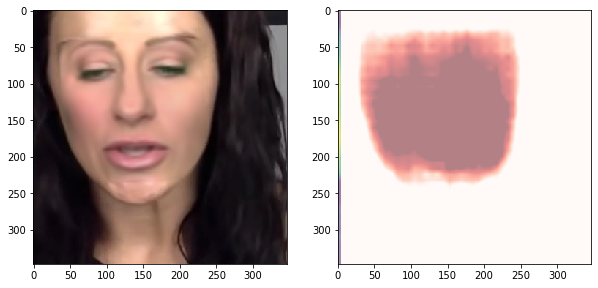

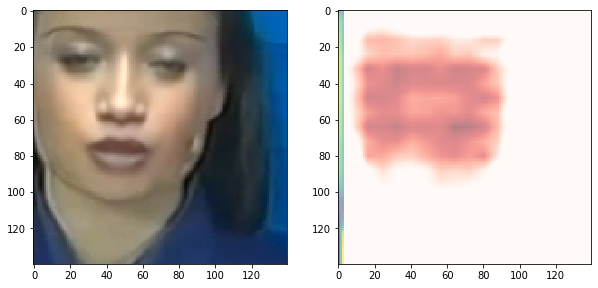

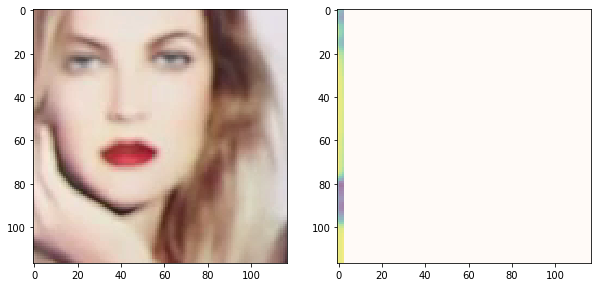

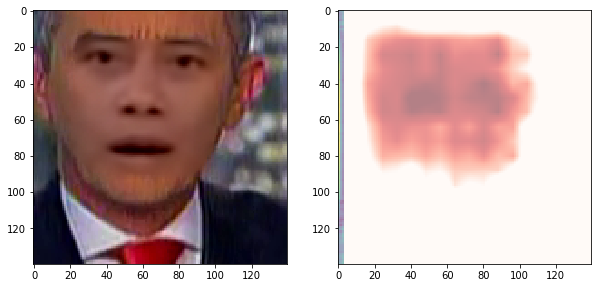

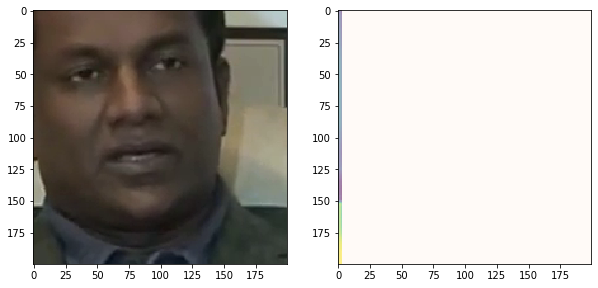

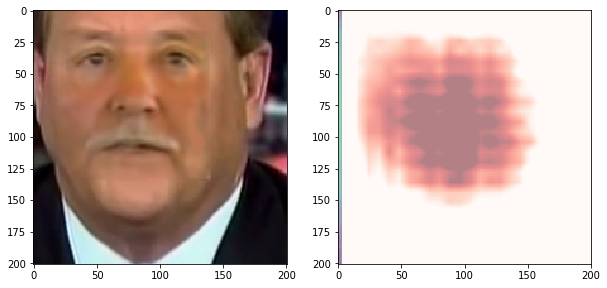

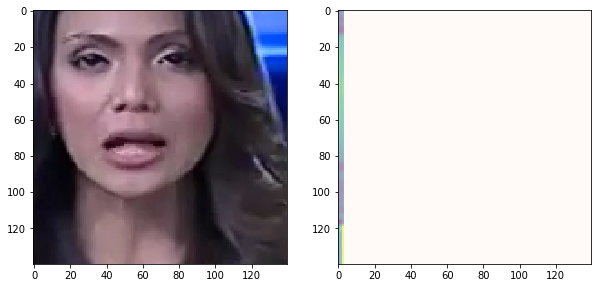

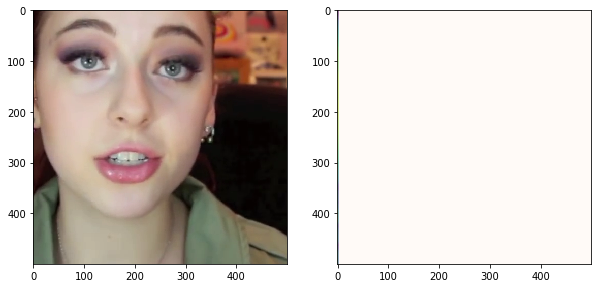

In [285]:
cnt_pixel = 0
cnt_pixel_old = 0
for i in range(MAX_FRAME_INFER):
    plt.figure(figsize=(10,7))
    cnt_pixel += hs[i]*ws[i]*3
    img_show = np.reshape(imgs1d[cnt_pixel_old:cnt_pixel], (hs[i],ws[i],3))
    cnt_pixel_old = cnt_pixel
    plt.subplot(1,2,1)
    plt.imshow( img_show )
    plt.subplot(1,2,2)
    plt.imshow( img_show[i][:hs[i],:ws[i]])
    mask = image_mask[i][:hs[i],:ws[i]]
    plt.imshow(mask, 'Reds', interpolation='none', alpha=0.5)
    plt.show()

In [290]:
model_to_use = '/datasets/FaceForensics/exp/mobilenetv2_dump/export/versions/11'
export_dir = os.path.join('models', model_to_use)

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    tf.saved_model.loader.load(sess, [tf.saved_model.tag_constants.SERVING], export_dir)

    # Creates the TensorInfo protobuf objects that encapsulates the input/output tensors
    x = loaded_graph.get_tensor_by_name( 'x:0' )
    height = loaded_graph.get_tensor_by_name( 'height:0' )
    width = loaded_graph.get_tensor_by_name( 'width:0' )
    output = loaded_graph.get_tensor_by_name( 'probmap:0' )
    
    logits = sess.run(output, {x:image,height:513, width:513})
    

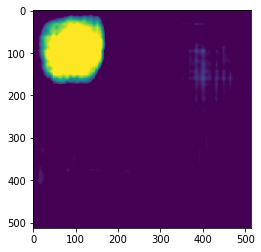

In [292]:
plt.imshow( np.squeeze(logits,axis=2) )

In [291]:
import subprocess
import re

ps = subprocess.Popen("ps -eaf | grep tensor_model_api", shell=True, stdout=subprocess.PIPE)
output = ps.stdout.readline()
ps.stdout.close()
ps.wait()
print(output)

b'root      2797  4360  0 14:13 ?        00:00:00 /bin/sh -c ps -eaf | grep tensor_model_api\n'
